# Multi-Objective Optimization Ax API
### Using the Service API
For Multi-objective optimization (MOO) in the `AxClient`, objectives are specified through the `ObjectiveProperties` dataclass.  An `ObjectiveProperties` requires a boolean `minimize`, and also accepts an optional floating point  `threshold`.  If a `threshold` is not specified, Ax will infer it through the use of heuristics.  If the user knows the region of interest (because they have specs or prior knowledge), then specifying the thresholds is preferable to inferring it. But if the user would need to guess, inferring is preferable.


To learn more about how to choose a threshold, see [Set Objective Thresholds to focus candidate generation in a region of interest](#Set-Objective-Thresholds-to-focus-candidate-generation-in-a-region-of-interest).  See the [Service API Tutorial](/tutorials/gpei_hartmann_service.html) for more infomation on running experiments with the Service API.

In [1]:
from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties

import torch

# Plotting imports and initialization
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.plot.pareto_utils import compute_posterior_pareto_frontier
from ax.plot.pareto_frontier import plot_pareto_frontier
init_notebook_plotting()

# Load our sample 2-objective problem
from botorch.test_functions.multi_objective import BraninCurrin
branin_currin = BraninCurrin(negate=True).to(
    dtype=torch.double, 
    device= torch.device("cuda" if torch.cuda.is_available() else "cpu"),
)

[INFO 09-15 03:03:07] ax.utils.notebook.plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.


In [2]:
ax_client = AxClient()
ax_client.create_experiment(
    name="moo_experiment",
    parameters=[
        {
            "name": f"x{i+1}",
            "type": "range",
            "bounds": [0.0, 1.0],
        }
        for i in range(2)
    ],
    objectives={
        # `threshold` arguments are optional
        "a": ObjectiveProperties(minimize=False, threshold=branin_currin.ref_point[0]), 
        "b": ObjectiveProperties(minimize=False, threshold=branin_currin.ref_point[1])
    },
    overwrite_existing_experiment=True,
    is_test=True,
)

[INFO 09-15 03:03:07] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 2 decimal points.


[INFO 09-15 03:03:07] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x1. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.


[INFO 09-15 03:03:07] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x2. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.


[INFO 09-15 03:03:07] ax.core.experiment: The is_test flag has been set to True. This flag is meant purely for development and integration testing purposes. If you are running a live experiment, please set this flag to False


[INFO 09-15 03:03:07] ax.modelbridge.dispatch_utils: Using Bayesian optimization since there are more ordered parameters than there are categories for the unordered categorical parameters.


[INFO 09-15 03:03:07] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+MOO', steps=[Sobol for 5 trials, MOO for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.


### Create an Evaluation Function
In the case of MOO experiments, evaluation functions can be any arbitrary function that takes in a `dict` of parameter names mapped to values and returns a `dict` of objective names mapped to a `tuple` of mean and SEM values.

In [3]:
def evaluate(parameters):
    evaluation = branin_currin(torch.tensor([parameters.get("x1"), parameters.get("x2")]))
    # In our case, standard error is 0, since we are computing a synthetic function.
    # Set standard error to None if the noise level is unknown.
    return {"a": (evaluation[0].item(), 0.0), "b": (evaluation[1].item(), 0.0)}

### Run Optimization

In [4]:
for i in range(25):
    parameters, trial_index = ax_client.get_next_trial()
    # Local evaluation here can be replaced with deployment to external system.
    ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate(parameters))

[INFO 09-15 03:03:07] ax.service.ax_client: Generated new trial 0 with parameters {'x1': 0.69, 'x2': 0.08}.


[INFO 09-15 03:03:07] ax.service.ax_client: Completed trial 0 with data: {'a': (-15.59, 0.0), 'b': (-10.76, 0.0)}.


[INFO 09-15 03:03:07] ax.service.ax_client: Generated new trial 1 with parameters {'x1': 0.31, 'x2': 0.37}.


[INFO 09-15 03:03:07] ax.service.ax_client: Completed trial 1 with data: {'a': (-20.24, 0.0), 'b': (-9.93, 0.0)}.


[INFO 09-15 03:03:07] ax.service.ax_client: Generated new trial 2 with parameters {'x1': 0.31, 'x2': 0.04}.


[INFO 09-15 03:03:07] ax.service.ax_client: Completed trial 2 with data: {'a': (-55.33, 0.0), 'b': (-13.29, 0.0)}.


[INFO 09-15 03:03:07] ax.service.ax_client: Generated new trial 3 with parameters {'x1': 0.98, 'x2': 0.67}.


[INFO 09-15 03:03:07] ax.service.ax_client: Completed trial 3 with data: {'a': (-54.66, 0.0), 'b': (-5.37, 0.0)}.


[INFO 09-15 03:03:07] ax.service.ax_client: Generated new trial 4 with parameters {'x1': 0.65, 'x2': 0.84}.


[INFO 09-15 03:03:07] ax.service.ax_client: Completed trial 4 with data: {'a': (-137.64, 0.0), 'b': (-4.89, 0.0)}.


[INFO 09-15 03:03:08] ax.service.ax_client: Generated new trial 5 with parameters {'x1': 0.0, 'x2': 1.0}.


[INFO 09-15 03:03:08] ax.service.ax_client: Completed trial 5 with data: {'a': (-17.51, 0.0), 'b': (-1.18, 0.0)}.


[INFO 09-15 03:03:08] ax.service.ax_client: Generated new trial 6 with parameters {'x1': 0.0, 'x2': 0.83}.


[INFO 09-15 03:03:08] ax.service.ax_client: Completed trial 6 with data: {'a': (-34.62, 0.0), 'b': (-1.35, 0.0)}.


[INFO 09-15 03:03:09] ax.service.ax_client: Generated new trial 7 with parameters {'x1': 0.14, 'x2': 1.0}.


[INFO 09-15 03:03:09] ax.service.ax_client: Completed trial 7 with data: {'a': (-11.24, 0.0), 'b': (-5.08, 0.0)}.


[INFO 09-15 03:03:10] ax.service.ax_client: Generated new trial 8 with parameters {'x1': 0.06, 'x2': 1.0}.


[INFO 09-15 03:03:10] ax.service.ax_client: Completed trial 8 with data: {'a': (-4.6, 0.0), 'b': (-3.43, 0.0)}.


[INFO 09-15 03:03:10] ax.service.ax_client: Generated new trial 9 with parameters {'x1': 0.0, 'x2': 0.46}.


[INFO 09-15 03:03:10] ax.service.ax_client: Completed trial 9 with data: {'a': (-117.99, 0.0), 'b': (-1.98, 0.0)}.


[INFO 09-15 03:03:11] ax.service.ax_client: Generated new trial 10 with parameters {'x1': 0.03, 'x2': 1.0}.


[INFO 09-15 03:03:11] ax.service.ax_client: Completed trial 10 with data: {'a': (-9.98, 0.0), 'b': (-2.26, 0.0)}.


[INFO 09-15 03:03:12] ax.service.ax_client: Generated new trial 11 with parameters {'x1': 1.0, 'x2': 0.0}.


[INFO 09-15 03:03:12] ax.service.ax_client: Completed trial 11 with data: {'a': (-10.96, 0.0), 'b': (-10.18, 0.0)}.


[INFO 09-15 03:03:13] ax.service.ax_client: Generated new trial 12 with parameters {'x1': 0.07, 'x2': 0.95}.


[INFO 09-15 03:03:14] ax.service.ax_client: Completed trial 12 with data: {'a': (-3.07, 0.0), 'b': (-3.99, 0.0)}.


[INFO 09-15 03:03:15] ax.service.ax_client: Generated new trial 13 with parameters {'x1': 0.04, 'x2': 0.98}.


[INFO 09-15 03:03:15] ax.service.ax_client: Completed trial 13 with data: {'a': (-7.51, 0.0), 'b': (-2.8, 0.0)}.


[INFO 09-15 03:03:18] ax.service.ax_client: Generated new trial 14 with parameters {'x1': 0.01, 'x2': 1.0}.


[INFO 09-15 03:03:18] ax.service.ax_client: Completed trial 14 with data: {'a': (-13.58, 0.0), 'b': (-1.71, 0.0)}.


[INFO 09-15 03:03:20] ax.service.ax_client: Generated new trial 15 with parameters {'x1': 0.09, 'x2': 0.92}.


[INFO 09-15 03:03:20] ax.service.ax_client: Completed trial 15 with data: {'a': (-1.55, 0.0), 'b': (-4.64, 0.0)}.


[INFO 09-15 03:03:22] ax.service.ax_client: Generated new trial 16 with parameters {'x1': 0.05, 'x2': 1.0}.


[INFO 09-15 03:03:22] ax.service.ax_client: Completed trial 16 with data: {'a': (-5.95, 0.0), 'b': (-3.05, 0.0)}.


[INFO 09-15 03:03:26] ax.service.ax_client: Generated new trial 17 with parameters {'x1': 0.11, 'x2': 0.86}.


[INFO 09-15 03:03:26] ax.service.ax_client: Completed trial 17 with data: {'a': (-0.6, 0.0), 'b': (-5.28, 0.0)}.


[INFO 09-15 03:03:26] ax.service.ax_client: Generated new trial 18 with parameters {'x1': 1.0, 'x2': 1.0}.


[INFO 09-15 03:03:26] ax.service.ax_client: Completed trial 18 with data: {'a': (-145.87, 0.0), 'b': (-4.01, 0.0)}.


[INFO 09-15 03:03:31] ax.service.ax_client: Generated new trial 19 with parameters {'x1': 0.03, 'x2': 1.0}.


[INFO 09-15 03:03:31] ax.service.ax_client: Completed trial 19 with data: {'a': (-8.48, 0.0), 'b': (-2.53, 0.0)}.


[INFO 09-15 03:03:37] ax.service.ax_client: Generated new trial 20 with parameters {'x1': 0.02, 'x2': 1.0}.


[INFO 09-15 03:03:38] ax.service.ax_client: Completed trial 20 with data: {'a': (-11.74, 0.0), 'b': (-1.98, 0.0)}.


[INFO 09-15 03:03:45] ax.service.ax_client: Generated new trial 21 with parameters {'x1': 0.08, 'x2': 0.94}.


[INFO 09-15 03:03:45] ax.service.ax_client: Completed trial 21 with data: {'a': (-2.24, 0.0), 'b': (-4.29, 0.0)}.


[INFO 09-15 03:03:56] ax.service.ax_client: Generated new trial 22 with parameters {'x1': 0.07, 'x2': 0.98}.


[INFO 09-15 03:03:56] ax.service.ax_client: Completed trial 22 with data: {'a': (-3.79, 0.0), 'b': (-3.7, 0.0)}.


[INFO 09-15 03:04:05] ax.service.ax_client: Generated new trial 23 with parameters {'x1': 0.1, 'x2': 0.89}.


[INFO 09-15 03:04:05] ax.service.ax_client: Completed trial 23 with data: {'a': (-1.02, 0.0), 'b': (-4.93, 0.0)}.


[INFO 09-15 03:04:09] ax.service.ax_client: Generated new trial 24 with parameters {'x1': 0.01, 'x2': 1.0}.


[INFO 09-15 03:04:09] ax.service.ax_client: Completed trial 24 with data: {'a': (-15.51, 0.0), 'b': (-1.44, 0.0)}.


### Plot Pareto Frontier

In [5]:
objectives = ax_client.experiment.optimization_config.objective.objectives
frontier = compute_posterior_pareto_frontier(
    experiment=ax_client.experiment,
    data=ax_client.experiment.fetch_data(),
    primary_objective=objectives[1].metric,
    secondary_objective=objectives[0].metric,
    absolute_metrics=["a", "b"],
    num_points=20,
)
render(plot_pareto_frontier(frontier, CI_level=0.90)) 

# Deep Dive

In the rest of this tutorial, we will show two algorithms available in Ax for multi-objective optimization
and visualize how they compare to eachother and to quasirandom search.

MOO covers the case where we care about multiple
outcomes in our experiment but we do not know before hand a specific weighting of those
objectives (covered by `ScalarizedObjective`) or a specific constraint on one objective 
(covered by `OutcomeConstraint`s) that will produce the best result.

The solution in this case is to find a whole Pareto frontier, a surface in outcome-space
containing points that can't be improved on in every outcome. This shows us the
tradeoffs between objectives that we can choose to make.

### Problem Statement

Optimize a list of M objective functions $ \bigl(f^{(1)}( x),..., f^{(M)}( x) \bigr)$ over a bounded search space $\mathcal X \subset \mathbb R^d$.

We assume $f^{(i)}$ are expensive-to-evaluate black-box functions with no known analytical expression, and no observed gradients. For instance, a machine learning model where we're interested in maximizing accuracy and minimizing inference time, with $\mathcal X$ the set of possible configuration spaces

### Pareto Optimality

In a multi-objective optimization problem, there typically is no single best solution. Rather, the *goal* is to identify the set of Pareto optimal solutions such that any improvement in one objective means deteriorating another. Provided with the Pareto set, decision-makers can select an objective trade-off according to their preferences. In the plot below, the red dots are the Pareto optimal solutions (assuming both objectives are to be minimized).
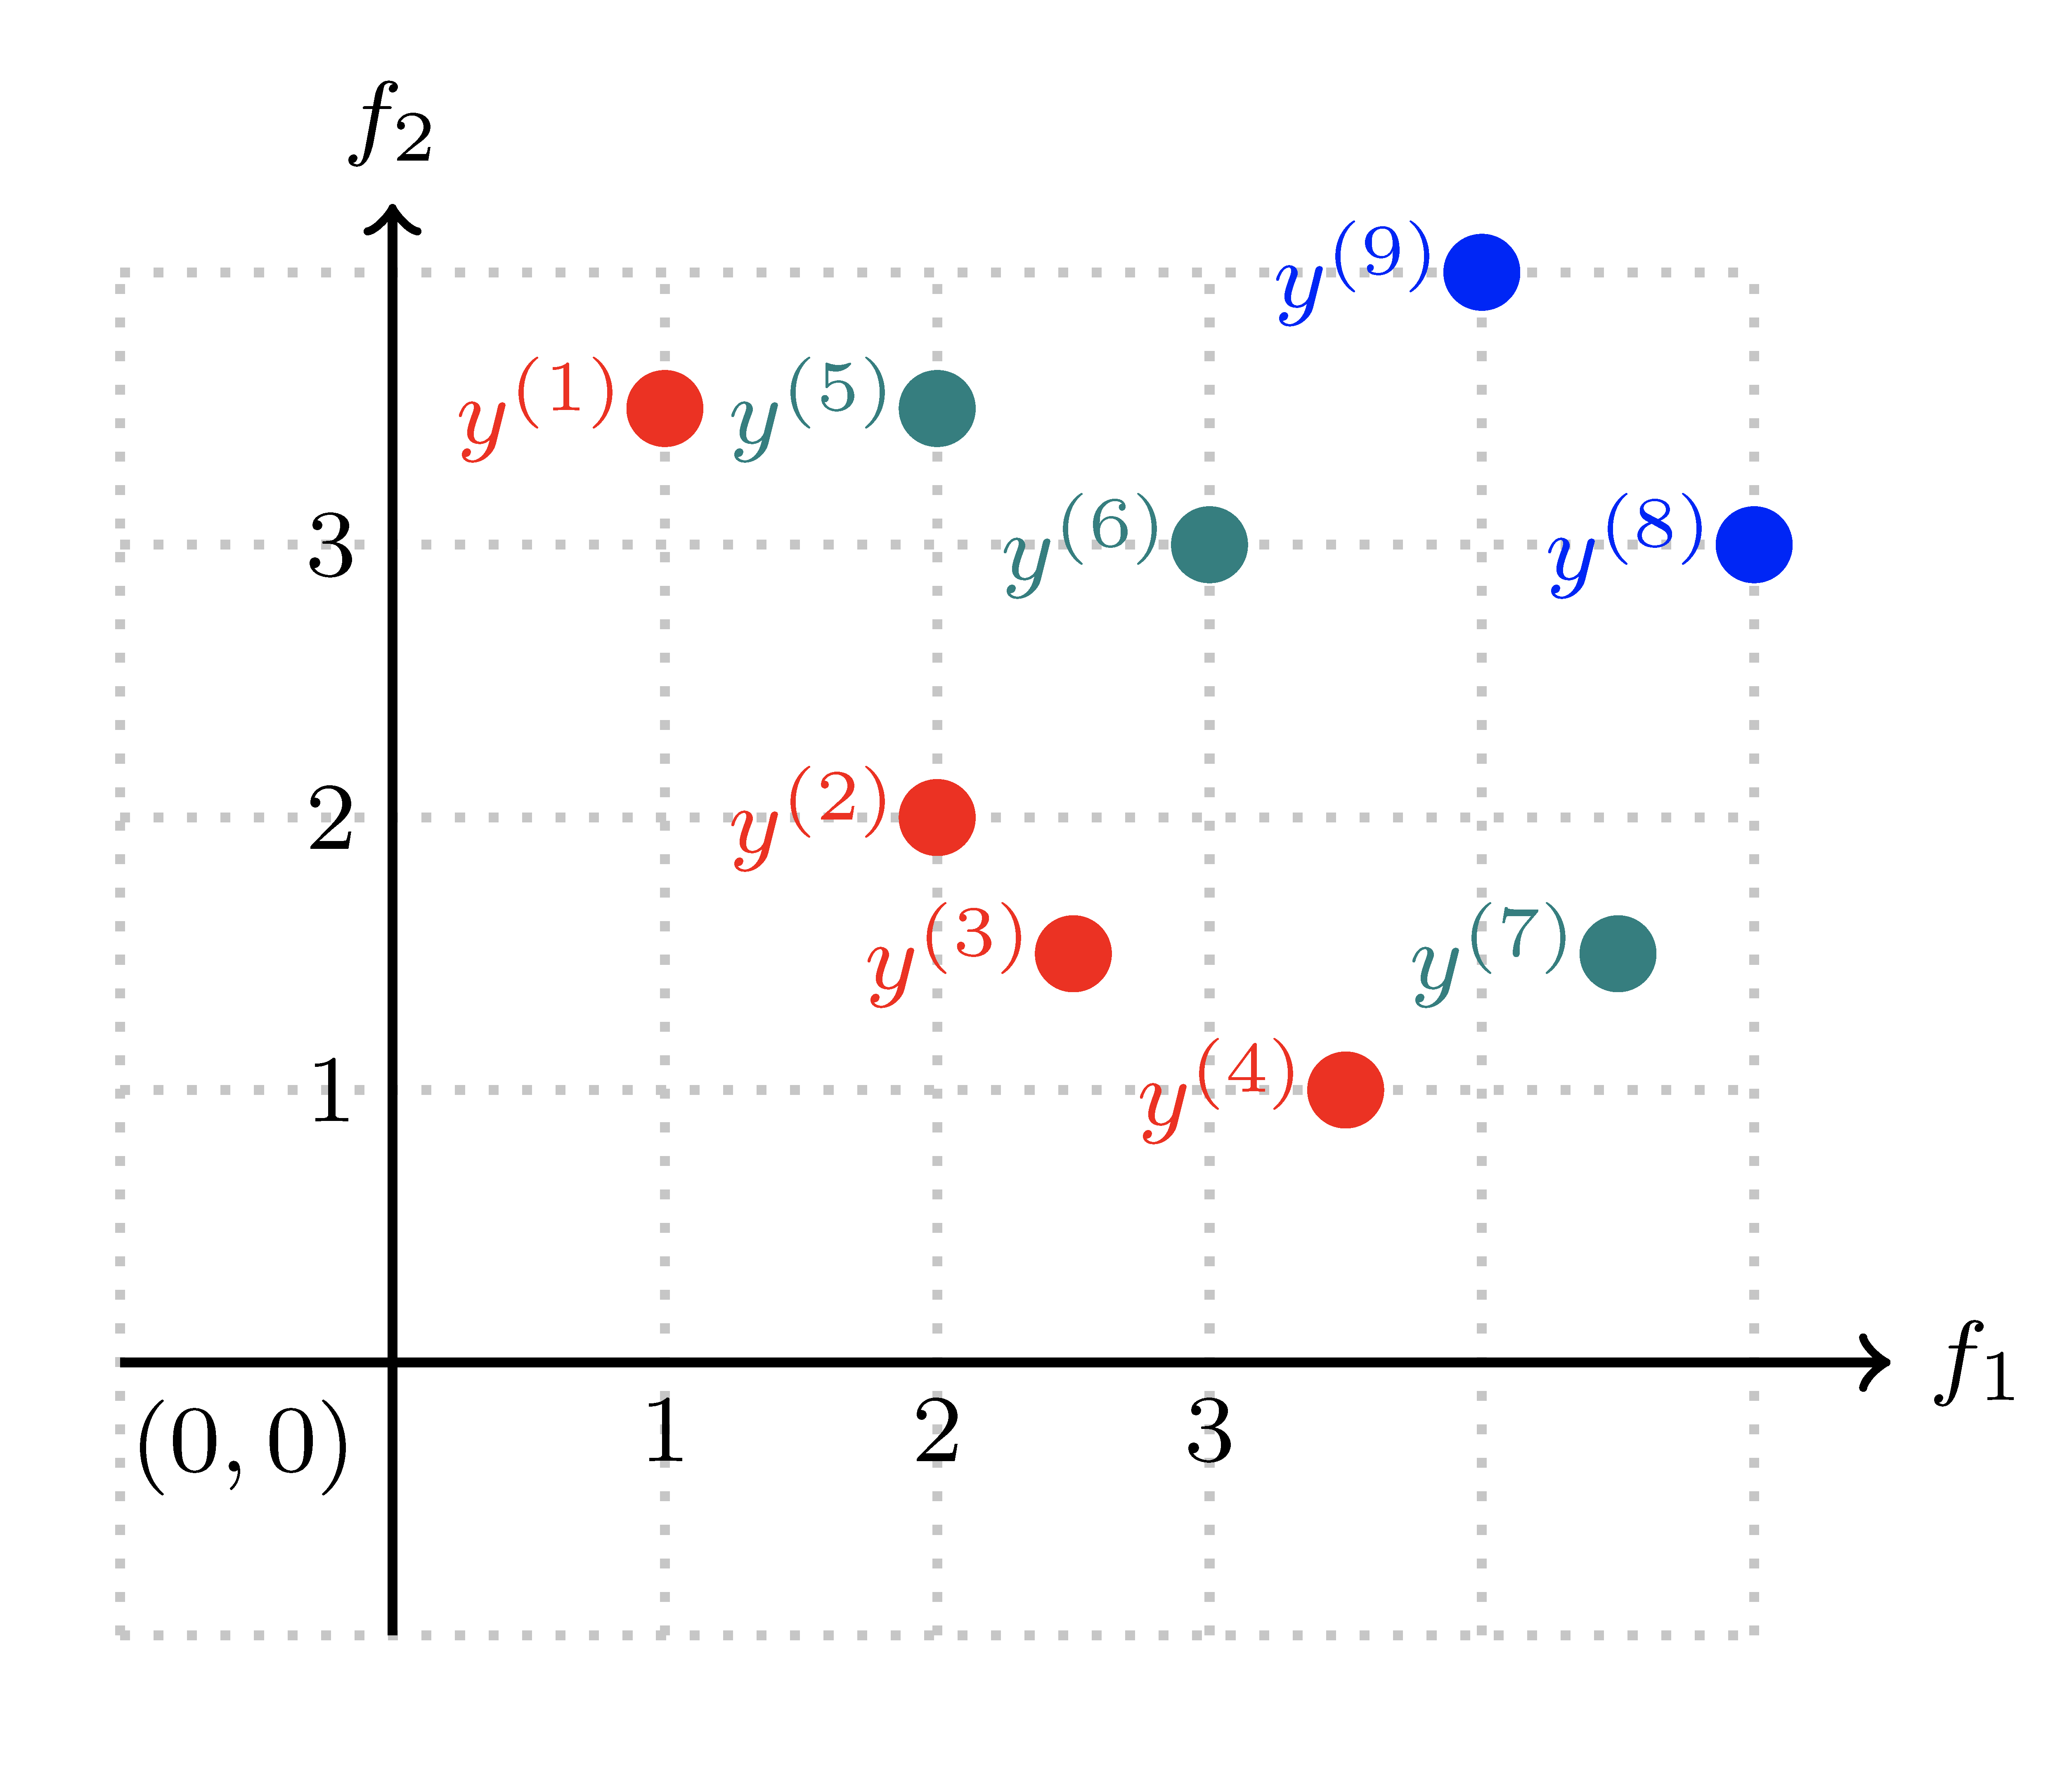

### Evaluating the Quality of a Pareto Front (Hypervolume)

Given a reference point $ r \in \mathbb R^M$, which we represent as a list of M `ObjectiveThreshold`s, one for each coordinate, the hypervolume (HV) of a Pareto set $\mathcal P = \{ y_i\}_{i=1}^{|\mathcal P|}$ is the volume of the space dominated (superior in every one of our M objectives) by $\mathcal P$ and bounded from above by a point $ r$. The reference point should be set to be slightly worse (10% is reasonable) than the worst value of each objective that a decision maker would tolerate. In the figure below, the grey area is the hypervolume in this 2-objective problem.
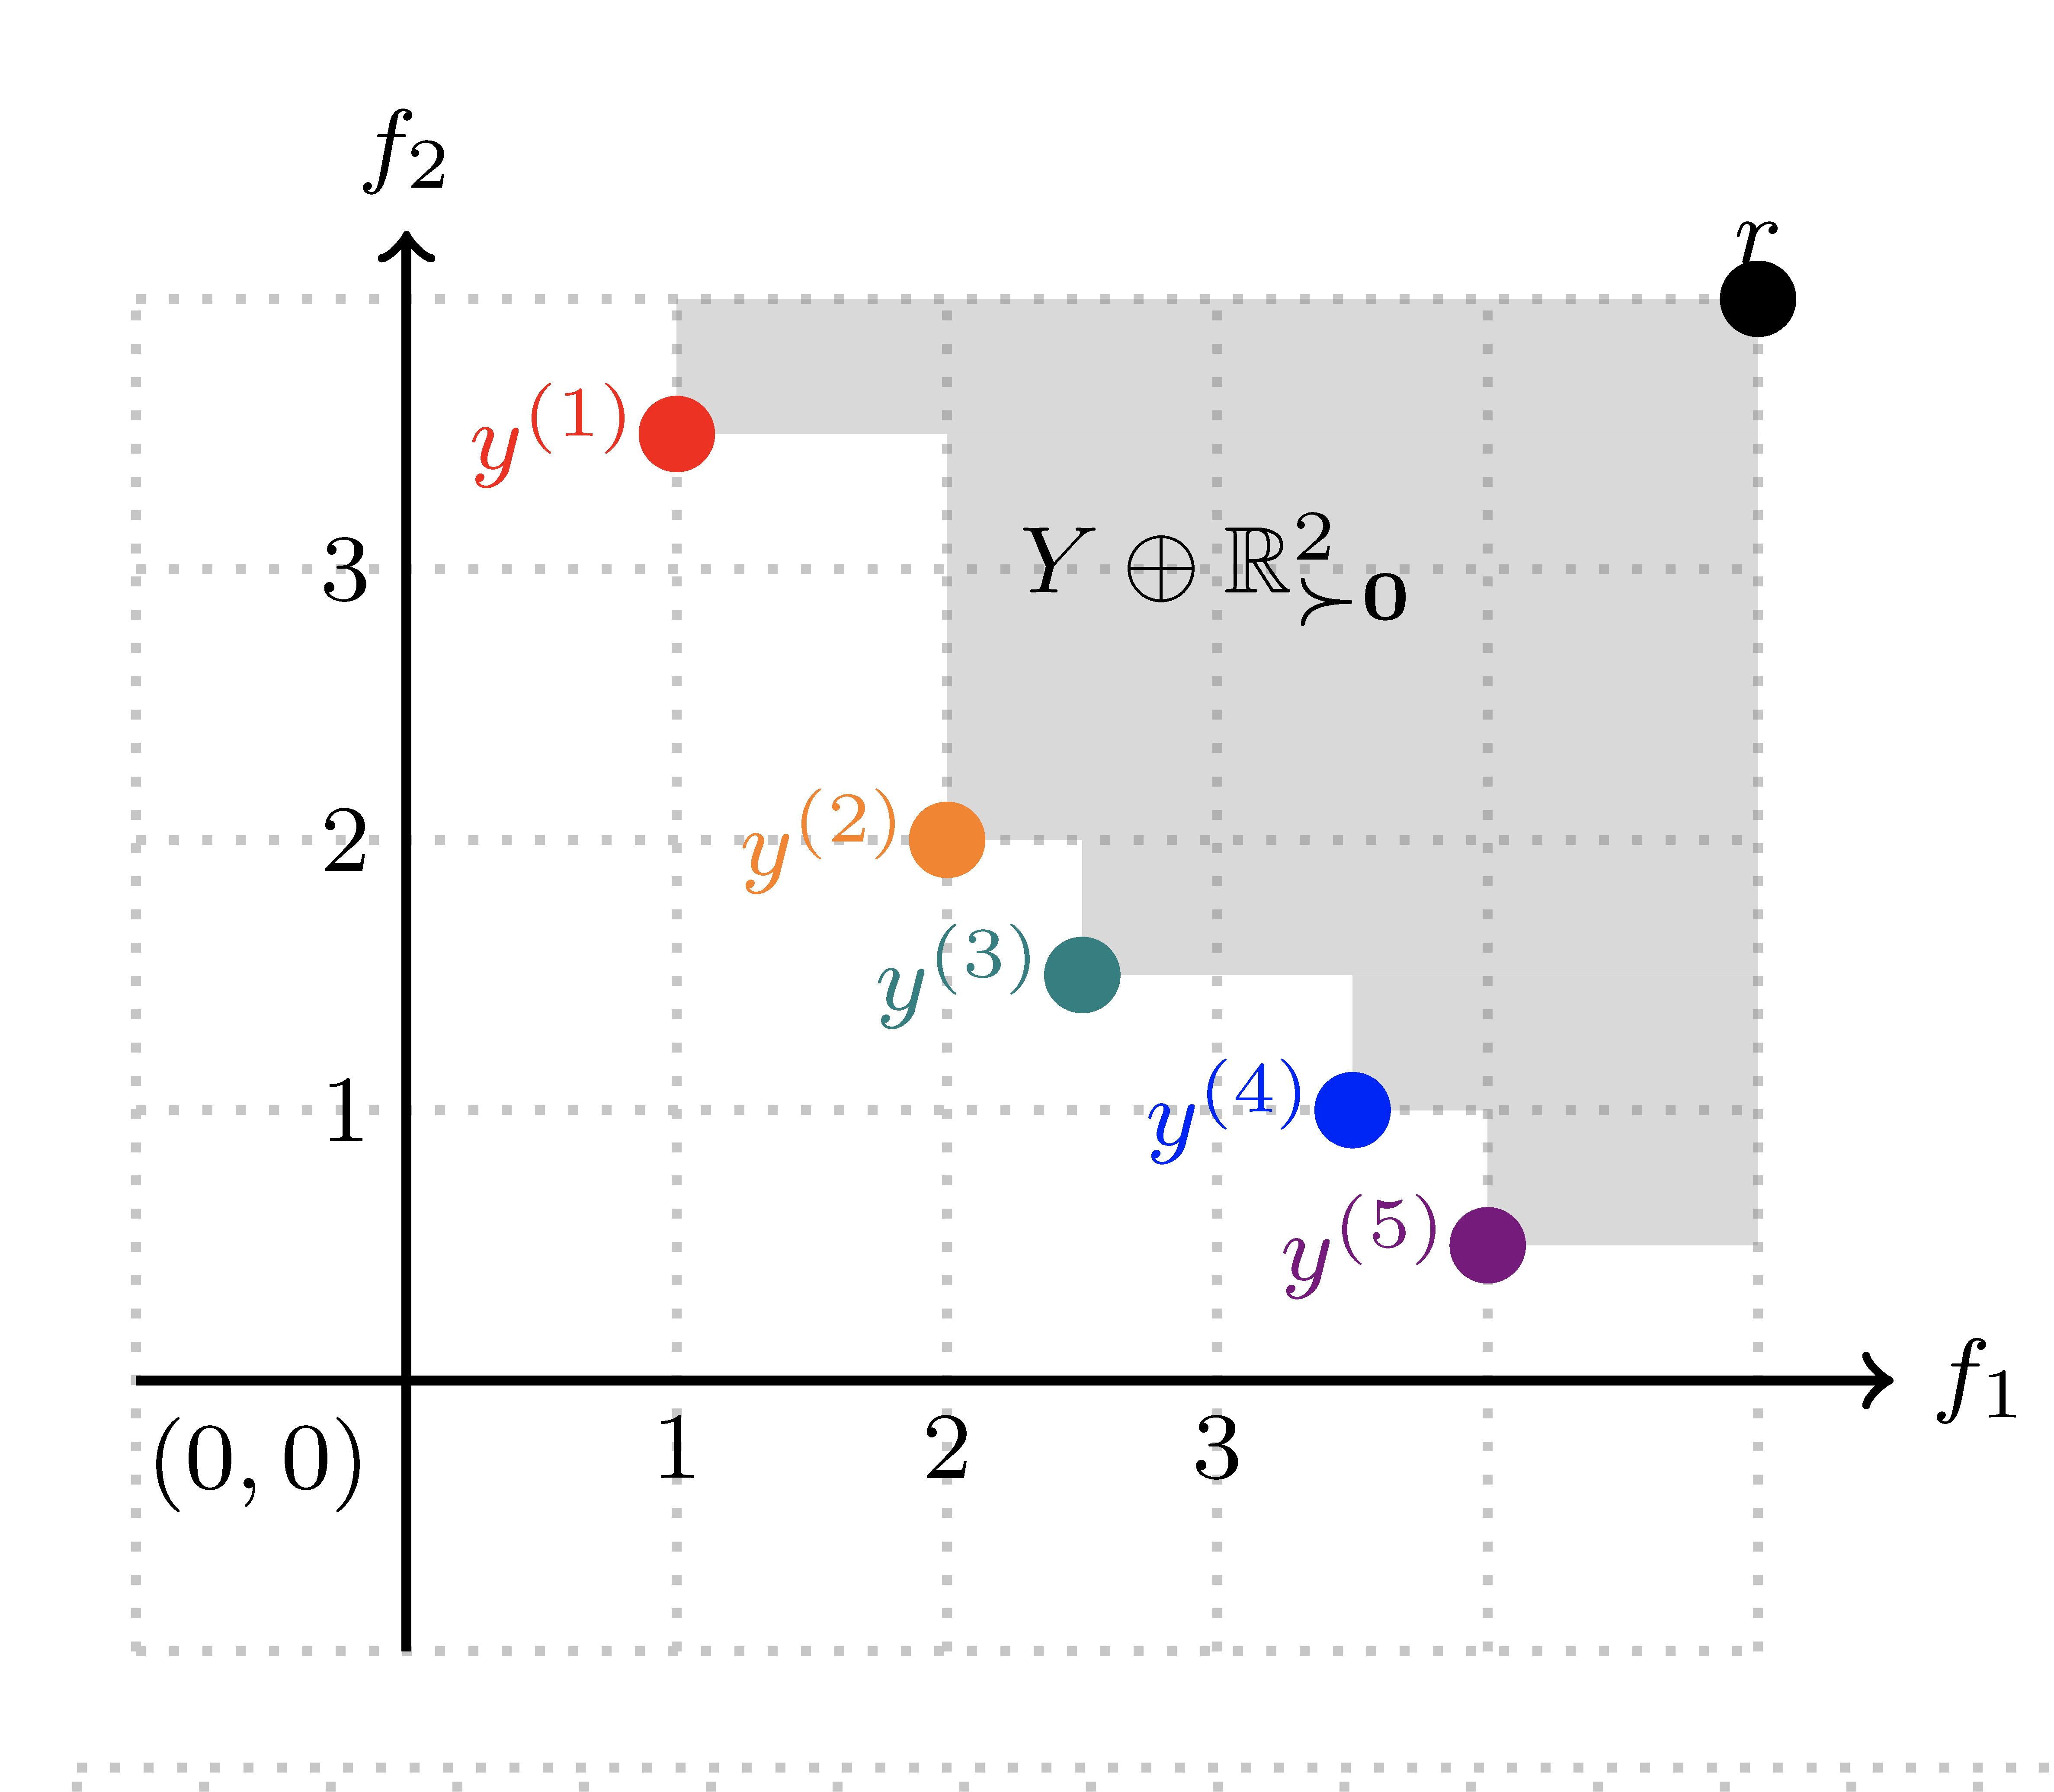

### Set Objective Thresholds to focus candidate generation in a region of interest

The below plots show three different sets of points generated by the qEVHI algorithm with different objective thresholds (aka reference points). Note that here we use absolute thresholds, but thresholds can also be relative to a status_quo arm.

The first plot shows the points without the `ObjectiveThreshold`s visible (they're set far below the origin of the graph).

The second shows the points generated with (-18, -6) as thresholds. The regions violating the thresholds are greyed out. Only the white region in the upper right exceeds both threshold, points in this region dominate the intersection of these thresholds (this intersection is the reference point). Only points in this region contribute to the hypervolume objective. A few exploration points are not in the valid region, but almost all the rest of the points are.

The third shows points generated with a very strict pair of thresholds, (-18, -2). Only the white region in the upper right exceeds both thresholds. Many points do not lie in the dominating region, but there are still more focused there than in the second examples.
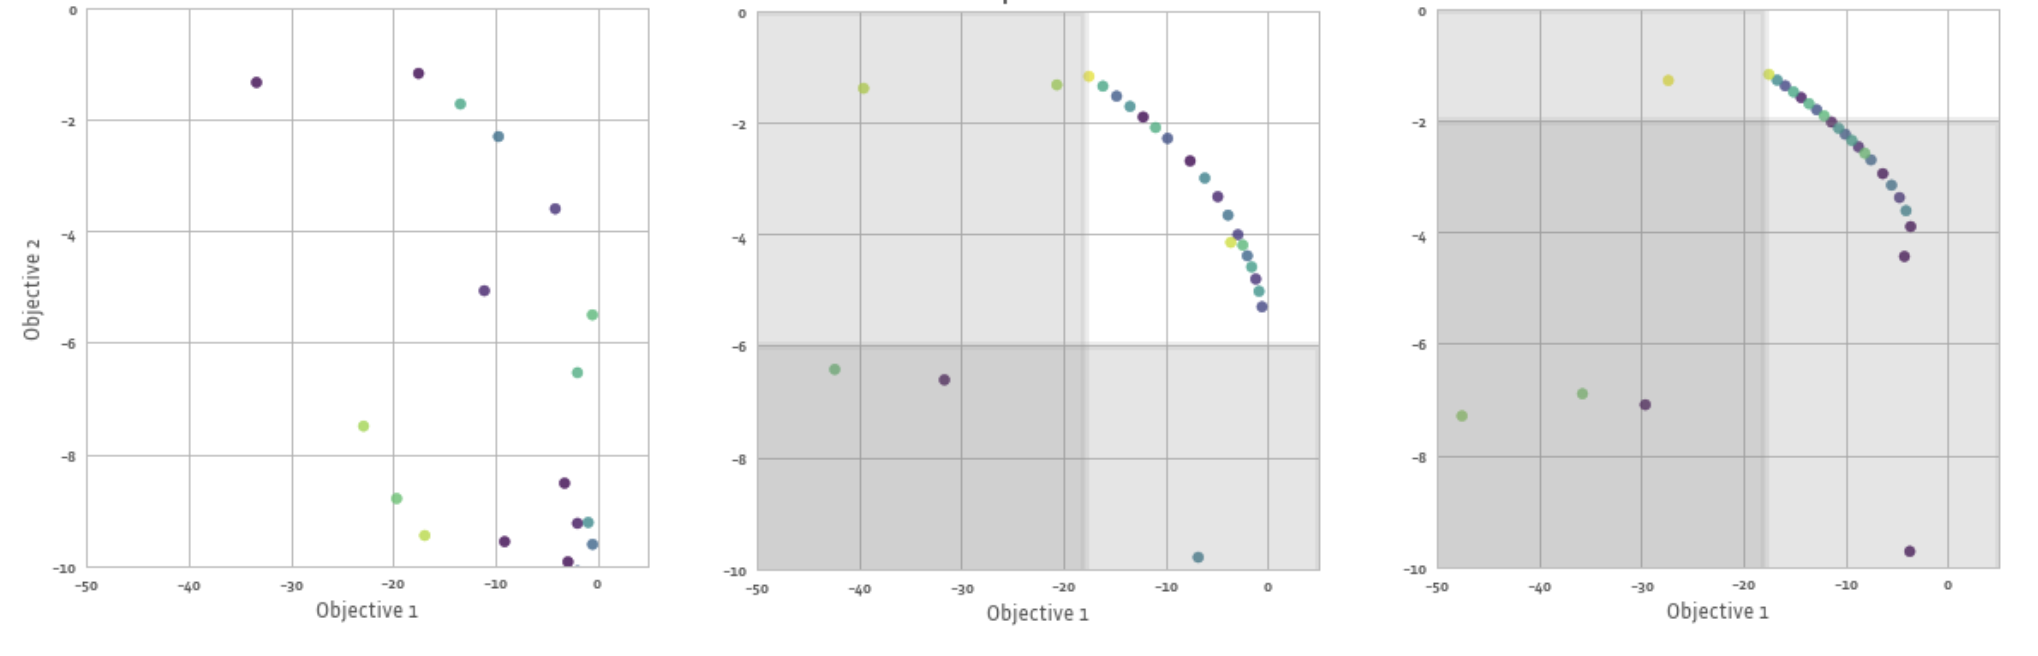

### Further Information

A deeper explanation of our the qEHVI and qParEGO algorithms this notebook explores can be found at https://arxiv.org/abs/2006.05078, and the underlying BoTorch implementation has a researcher-oriented tutorial at https://botorch.org/tutorials/multi_objective_bo.

## Setup

In [6]:
import pandas as pd
from ax import *

import numpy as np

from ax.metrics.noisy_function import NoisyFunctionMetric
from ax.service.utils.report_utils import exp_to_df
from ax.runners.synthetic import SyntheticRunner

# Factory methods for creating multi-objective optimization modesl.
from ax.modelbridge.factory import get_MOO_EHVI, get_MOO_PAREGO

# Analysis utilities, including a method to evaluate hypervolumes
from ax.modelbridge.modelbridge_utils import observed_hypervolume

## Define experiment configurations

### Search Space

In [7]:
x1 = RangeParameter(name="x1", lower=0, upper=1, parameter_type=ParameterType.FLOAT)
x2 = RangeParameter(name="x2", lower=0, upper=1, parameter_type=ParameterType.FLOAT)

search_space = SearchSpace(
    parameters=[x1, x2],
)

### MultiObjectiveOptimizationConfig

To optimize multiple objective we must create a `MultiObjective` containing the metrics we'll optimize and `MultiObjectiveOptimizationConfig` (which contains `ObjectiveThreshold`s) instead of our more typical `Objective` and `OptimizationConfig`

We define `NoisyFunctionMetric`s to wrap our synthetic Branin-Currin problem's outputs. Add noise to see how robust our different optimization algorithms are.

In [8]:
class MetricA(NoisyFunctionMetric):
    def f(self, x: np.ndarray) -> float:
        return float(branin_currin(torch.tensor(x))[0])
    
class MetricB(NoisyFunctionMetric):
    def f(self, x: np.ndarray) -> float:
        return float(branin_currin(torch.tensor(x))[1])

metric_a = MetricA("a", ["x1", "x2"], noise_sd=0.0, lower_is_better=False)
metric_b = MetricB("b", ["x1", "x2"], noise_sd=0.0, lower_is_better=False)

In [9]:
mo = MultiObjective(
    objectives=[Objective(metric=metric_a), Objective(metric=metric_b)],
)

In [10]:
objective_thresholds = [
    ObjectiveThreshold(metric=metric, bound=val, relative=False)
    for metric, val in zip(mo.metrics, branin_currin.ref_point)
]

In [11]:
optimization_config = MultiObjectiveOptimizationConfig(
    objective=mo,
    objective_thresholds=objective_thresholds,
)

## Define experiment creation utilities

These construct our experiment, then initialize with Sobol points before we fit a Gaussian Process model to those initial points.

In [12]:
# Reasonable defaults for number of quasi-random initialization points and for subsequent model-generated trials.
N_INIT = 6
N_BATCH = 25

In [13]:
def build_experiment():
    experiment = Experiment(
        name="pareto_experiment",
        search_space=search_space,
        optimization_config=optimization_config,
        runner=SyntheticRunner(),
    )
    return experiment

In [14]:
## Initialize with Sobol samples

def initialize_experiment(experiment):
    sobol = Models.SOBOL(search_space=experiment.search_space, seed=1234)

    for _ in range(N_INIT):
        experiment.new_trial(sobol.gen(1)).run()

    return experiment.fetch_data()

# Sobol
We use quasirandom points as a fast baseline for evaluating the quality of our multi-objective optimization algorithms.

In [15]:
sobol_experiment = build_experiment()
sobol_data = initialize_experiment(sobol_experiment)

In [16]:
sobol_model = Models.SOBOL(
    experiment=sobol_experiment, 
    data=sobol_data,
)
sobol_hv_list = []
for i in range(N_BATCH):
    generator_run = sobol_model.gen(1)
    trial = sobol_experiment.new_trial(generator_run=generator_run)
    trial.run()
    exp_df = exp_to_df(sobol_experiment)
    outcomes = np.array(exp_df[['a', 'b']], dtype=np.double)
    # Fit a GP-based model in order to calculate hypervolume.
    # We will not use this model to generate new points.
    dummy_model = get_MOO_EHVI(
        experiment=sobol_experiment, 
        data=sobol_experiment.fetch_data(),
    )
    try:
        hv = observed_hypervolume(modelbridge=dummy_model)
    except:
        hv = 0
        print("Failed to compute hv")
    sobol_hv_list.append(hv)
    print(f"Iteration: {i}, HV: {hv}")

sobol_outcomes = np.array(exp_to_df(sobol_experiment)[['a', 'b']], dtype=np.double)

[WARNING 09-15 03:04:16] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 0, HV: 0.0


[WARNING 09-15 03:04:17] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 1, HV: 0.0


[WARNING 09-15 03:04:17] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 2, HV: 0.0


[WARNING 09-15 03:04:18] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 3, HV: 0.0


[WARNING 09-15 03:04:19] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 4, HV: 0.0


[WARNING 09-15 03:04:19] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 5, HV: 0.0


[WARNING 09-15 03:04:20] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 6, HV: 0.0


[WARNING 09-15 03:04:21] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 7, HV: 0.0


[WARNING 09-15 03:04:22] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 8, HV: 0.0


[WARNING 09-15 03:04:23] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 9, HV: 0.0


[WARNING 09-15 03:04:24] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 10, HV: 0.0


[WARNING 09-15 03:04:25] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 11, HV: 0.0


[WARNING 09-15 03:04:27] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 12, HV: 0.0


[WARNING 09-15 03:04:28] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 13, HV: 0.0


[WARNING 09-15 03:04:29] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 14, HV: 0.0


[WARNING 09-15 03:04:31] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 15, HV: 0.0


[WARNING 09-15 03:04:32] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 16, HV: 0.0


[WARNING 09-15 03:04:33] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 17, HV: 0.0


[WARNING 09-15 03:04:35] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 18, HV: 0.0


[WARNING 09-15 03:04:37] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 19, HV: 0.0


[WARNING 09-15 03:04:38] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 20, HV: 0.0


[WARNING 09-15 03:04:40] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 21, HV: 0.0


[WARNING 09-15 03:04:42] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 22, HV: 34.51762043030251


[WARNING 09-15 03:04:44] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 23, HV: 34.51762043030251


[WARNING 09-15 03:04:46] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 24, HV: 34.51762043030251


[WARNING 09-15 03:04:48] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


## qEHVI
Expected HyperVolume Improvement. This is our current recommended algorithm for multi-objective optimization, when a reference point is already known.

In [17]:
ehvi_experiment = build_experiment()
ehvi_data = initialize_experiment(ehvi_experiment)

In [18]:
ehvi_hv_list = []
ehvi_model = None
for i in range(N_BATCH):   
    ehvi_model = get_MOO_EHVI(
        experiment=ehvi_experiment, 
        data=ehvi_data,
    )
    generator_run = ehvi_model.gen(1)
    trial = ehvi_experiment.new_trial(generator_run=generator_run)
    trial.run()
    ehvi_data = Data.from_multiple_data([ehvi_data, trial.fetch_data()])
    
    exp_df = exp_to_df(ehvi_experiment)
    outcomes = np.array(exp_df[['a', 'b']], dtype=np.double)
    try:
        hv = observed_hypervolume(modelbridge=ehvi_model)
    except:
        hv = 0
        print("Failed to compute hv")
    ehvi_hv_list.append(hv)
    print(f"Iteration: {i}, HV: {hv}")

ehvi_outcomes = np.array(exp_to_df(ehvi_experiment)[['a', 'b']], dtype=np.double)

[WARNING 09-15 03:04:49] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 0, HV: 0.0


[WARNING 09-15 03:04:50] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 1, HV: 0.0


[WARNING 09-15 03:04:52] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 2, HV: 0.0


[WARNING 09-15 03:04:54] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 3, HV: 0.0


[WARNING 09-15 03:04:55] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 4, HV: 29.721429444561164


[WARNING 09-15 03:04:58] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 5, HV: 42.45964192453365


[WARNING 09-15 03:04:59] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 6, HV: 47.177075577228514


[WARNING 09-15 03:05:01] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 7, HV: 50.00553215141164


[WARNING 09-15 03:05:03] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 8, HV: 51.55502414785271


[WARNING 09-15 03:05:06] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 9, HV: 52.82934382348292


[WARNING 09-15 03:05:08] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 10, HV: 53.49525088668184


[WARNING 09-15 03:05:10] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 11, HV: 53.99226538811502


[WARNING 09-15 03:05:12] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 12, HV: 53.99226538811502


[WARNING 09-15 03:05:15] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 13, HV: 54.963151025010134


[WARNING 09-15 03:05:17] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 14, HV: 55.303273132277425


[WARNING 09-15 03:05:20] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 15, HV: 55.65265084388061


[WARNING 09-15 03:05:22] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 16, HV: 55.968138691535955


[WARNING 09-15 03:05:25] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 17, HV: 56.27319857554562


[WARNING 09-15 03:05:28] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 18, HV: 56.50749048221276


[WARNING 09-15 03:05:30] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 19, HV: 56.652882268963495


[WARNING 09-15 03:05:33] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 20, HV: 56.77898820093239


[WARNING 09-15 03:05:36] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 21, HV: 56.93002579852782


[WARNING 09-15 03:05:38] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 22, HV: 57.041807009122856


[WARNING 09-15 03:05:40] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 23, HV: 57.1244915204244


[WARNING 09-15 03:05:43] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 24, HV: 57.21012126541433


[WARNING 09-15 03:05:44] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


## Plot qEHVI Pareto Frontier based on model posterior 

The plotted points are samples from the fitted model's posterior, not observed samples.

In [19]:
frontier = compute_posterior_pareto_frontier(
    experiment=ehvi_experiment,
    data=ehvi_experiment.fetch_data(),
    primary_objective=metric_b,
    secondary_objective=metric_a,
    absolute_metrics=["a", "b"],
    num_points=20,
)

render(plot_pareto_frontier(frontier, CI_level=0.90)) 

## qParEGO
This is a good alternative algorithm for multi-objective optimization when qEHVI runs too slowly or produces poor results.

In [20]:
parego_experiment = build_experiment()
parego_data = initialize_experiment(parego_experiment)

In [21]:
parego_hv_list = []
parego_model = None
for i in range(N_BATCH):   
    parego_model = get_MOO_PAREGO(
        experiment=parego_experiment, 
        data=parego_data,
    )
    generator_run = parego_model.gen(1)
    trial = parego_experiment.new_trial(generator_run=generator_run)
    trial.run()
    parego_data = Data.from_multiple_data([parego_data, trial.fetch_data()])
    
    exp_df = exp_to_df(parego_experiment)
    outcomes = np.array(exp_df[['a', 'b']], dtype=np.double)
    try:
        hv = observed_hypervolume(modelbridge=parego_model)
    except:
        hv = 0
        print("Failed to compute hv")
    parego_hv_list.append(hv)
    print(f"Iteration: {i}, HV: {hv}")

parego_outcomes = np.array(exp_to_df(parego_experiment)[['a', 'b']], dtype=np.double)

[WARNING 09-15 03:05:53] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 0, HV: 0.0


[WARNING 09-15 03:05:54] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 1, HV: 0.0


[WARNING 09-15 03:05:55] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 2, HV: 0.0


[WARNING 09-15 03:05:56] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 3, HV: 0.0


[WARNING 09-15 03:05:57] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 4, HV: 11.143569440193227


[WARNING 09-15 03:05:58] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 5, HV: 30.706961441810027


[WARNING 09-15 03:05:59] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 6, HV: 39.743876676531414


[WARNING 09-15 03:06:00] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 7, HV: 40.2474183896416


[WARNING 09-15 03:06:01] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 8, HV: 42.76332727046977


[WARNING 09-15 03:06:02] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 9, HV: 44.97695010217578


[WARNING 09-15 03:06:03] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 10, HV: 44.97695010217578


[WARNING 09-15 03:06:04] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 11, HV: 44.97695010217578


[WARNING 09-15 03:06:06] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 12, HV: 44.97695010217578


[WARNING 09-15 03:06:07] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 13, HV: 44.97695010217578


[WARNING 09-15 03:06:08] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 14, HV: 44.97695010217578


[WARNING 09-15 03:06:09] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 15, HV: 46.934799379842374


[WARNING 09-15 03:06:10] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 16, HV: 46.934799379842374


[WARNING 09-15 03:06:11] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 17, HV: 46.934799379842374


[WARNING 09-15 03:06:12] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 18, HV: 46.934799379842374


[WARNING 09-15 03:06:14] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 19, HV: 46.934799379842374


[WARNING 09-15 03:06:15] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 20, HV: 51.55968062189473


[WARNING 09-15 03:06:16] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 21, HV: 51.840709135029144


[WARNING 09-15 03:06:18] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 22, HV: 51.840709135029144


[WARNING 09-15 03:06:19] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 23, HV: 53.33666134850596


[WARNING 09-15 03:06:20] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


Iteration: 24, HV: 53.33666134850596


[WARNING 09-15 03:06:21] ax.service.utils.report_utils: Ignoring user-specified `deduplicate_on_map_keys = True` since `exp.fetch_data().map_keys` is empty or does not exist. Check that at least one element of `metrics` (or `exp.metrics` if `metrics is None`) inherits from `MapMetric`.


## Plot qParEGO Pareto Frontier based on model posterior 

The plotted points are samples from the fitted model's posterior, not observed samples.

In [22]:
frontier = compute_posterior_pareto_frontier(
    experiment=parego_experiment,
    data=parego_experiment.fetch_data(),
    primary_objective=metric_b,
    secondary_objective=metric_a,
    absolute_metrics=["a", "b"],
    num_points=20,
)

render(plot_pareto_frontier(frontier, CI_level=0.90)) 

## Plot empirical data

#### Plot observed hypervolume, with color representing the iteration that a point was generated on.

To examine optimization process from another perspective, we plot the collected observations under each algorithm where the color corresponds to the BO iteration at which the point was collected. The plot on the right for $q$EHVI shows that the $q$EHVI quickly identifies the Pareto front and most of its evaluations are very close to the Pareto front. $q$ParEGO also identifies has many observations close to the Pareto front, but relies on optimizing random scalarizations, which is a less principled way of optimizing the Pareto front compared to $q$EHVI, which explicitly attempts focuses on improving the Pareto front. Sobol generates random points and has few points close to the Pareto front.

Text(0.5, 1.0, 'Iteration')

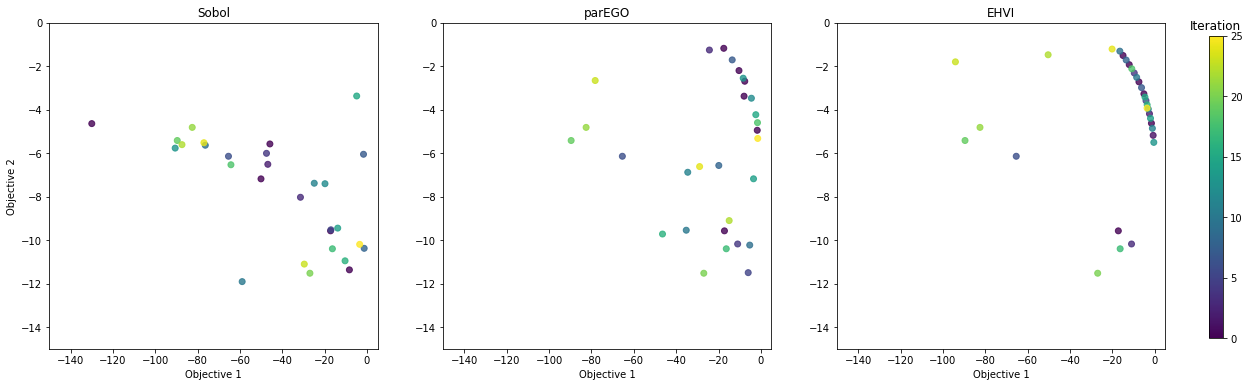

In [23]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from matplotlib.cm import ScalarMappable
fig, axes = plt.subplots(1, 3, figsize=(20,6))
algos = ["Sobol", "parEGO", "EHVI"]
outcomes_list = [sobol_outcomes, parego_outcomes, ehvi_outcomes]
cm = plt.cm.get_cmap('viridis')
BATCH_SIZE = 1

n_results = N_BATCH*BATCH_SIZE + N_INIT
batch_number = torch.cat([torch.zeros(N_INIT), torch.arange(1, N_BATCH+1).repeat(BATCH_SIZE, 1).t().reshape(-1)]).numpy()
for i, train_obj in enumerate(outcomes_list):
    x = i
    sc = axes[x].scatter(train_obj[:n_results, 0], train_obj[:n_results,1], c=batch_number[:n_results], alpha=0.8)
    axes[x].set_title(algos[i])
    axes[x].set_xlabel("Objective 1")
    axes[x].set_xlim(-150, 5)
    axes[x].set_ylim(-15, 0)
axes[0].set_ylabel("Objective 2")
norm = plt.Normalize(batch_number.min(), batch_number.max())
sm =  ScalarMappable(norm=norm, cmap=cm)
sm.set_array([])
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.set_title("Iteration")

# Hypervolume statistics
The hypervolume of the space dominated by points that dominate the reference point.

#### Plot the results
The plot below shows a common metric of multi-objective optimization performance when the true Pareto frontier is known:  the log difference between the hypervolume of the true Pareto front and the hypervolume of the approximate Pareto front identified by each algorithm. The log hypervolume difference is plotted at each step of the optimization for each of the algorithms.

The plot show that $q$EHVI vastly outperforms $q$ParEGO which outperforms the Sobol baseline.

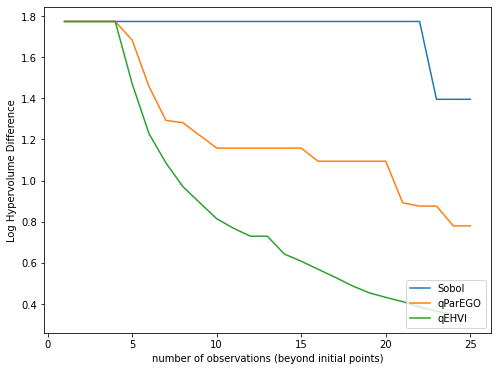

In [24]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

iters = np.arange(1, N_BATCH + 1)
log_hv_difference_sobol = np.log10(branin_currin.max_hv - np.asarray(sobol_hv_list))[:N_BATCH + 1]
log_hv_difference_parego = np.log10(branin_currin.max_hv - np.asarray(parego_hv_list))[:N_BATCH + 1]
log_hv_difference_ehvi = np.log10(branin_currin.max_hv - np.asarray(ehvi_hv_list))[:N_BATCH + 1]

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(iters, log_hv_difference_sobol, label="Sobol", linewidth=1.5)
ax.plot(iters, log_hv_difference_parego, label="qParEGO", linewidth=1.5)
ax.plot(iters, log_hv_difference_ehvi, label="qEHVI", linewidth=1.5)
ax.set(xlabel='number of observations (beyond initial points)', ylabel='Log Hypervolume Difference')
ax.legend(loc="lower right")